In [1]:
import copy
import matplotlib.pyplot as plt

import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

from devinterp.optim.sgld import SGLD
from devinterp.optim.sgnht import SGNHT

from joblib import Parallel, delayed

DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
# DEVICE = "cpu"
PRIMARY, SECONDARY, TERTIARY = sns.color_palette("muted")[:3]
PRIMARY_LIGHT, SECONDARY_LIGHT, TERTIARY_LIGHT = sns.color_palette("pastel")[:3]
def train_one_epoch(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    for data, target in (train_loader):
        optimizer.zero_grad()
        output = model(data.to(DEVICE))
        loss = criterion(output, target.to(DEVICE))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss / len(train_loader)


def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.to(DEVICE))
            loss = criterion(output, target.to(DEVICE))
            test_loss += loss.item()
    return test_loss / len(test_loader)


# class ResidualBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, stride=1, downsample=None):
#         super().__init__()
#         self.conv1 = nn.Conv2d(
#             in_channels, out_channels, kernel_size=3, stride=stride, padding=1
#         )
#         self.bn1 = nn.BatchNorm2d(out_channels)
#         self.relu = nn.ReLU(inplace=True)
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
#         self.bn2 = nn.BatchNorm2d(out_channels)
#         self.downsample = downsample

#     def forward(self, x):
#         identity = x
#         out = self.bn1(self.conv1(x))
#         out = self.relu(out)
#         out = self.bn2(self.conv2(out))
#         if self.downsample:
#             identity = self.downsample(x)
#         out += identity
#         out = self.relu(out)
#         return out

# class Net(nn.Module):
#     def __init__(self, input_dim=28 * 28, depth=4, num_classes=10):
#         super().__init__()
#         assert depth%2 == 0, "depth must be even"
#         # res blocks upto depth/2 followed by a linear layer
#         for i in range(depth//2):
#             setattr(self, f"resblock_{i}", ResidualBlock(1, 1))
#         self.linear = nn.Linear(input_dim, num_classes)
#         self.depth = depth

#     def forward(self, x):
#         for i in range(self.depth//2):
#             x = getattr(self, f"resblock_{i}")(x)
#             # if i < 2:
#             #     x = F.max_pool2d(x, 2)
#         x = x.view(x.size(0), -1)
#         x = self.linear(x)
#         x = F.softmax(x, dim=-1)
#         return x

from resnets import Net
        
# DEVICE = "cuda"
# Load MNIST data

# Load MNIST data
MNIST_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        # transforms.view(1, 28, 28),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)
batch_size = 512
train_data = datasets.MNIST("../data", train=True, transform=MNIST_transform, download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# Load test data
test_data = datasets.MNIST("../data", train=False, transform=MNIST_transform)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(len(train_data))
criterion = nn.CrossEntropyLoss()
lr = 0.005

from tqdm import tqdm

def train_model_size(depth, n_epochs=20, lr=0.005, weight_decay=0,
                     verbose=False):
    train_loss_trajectories = []
    test_loss_trajectories = []
    model = Net(depth=depth).to(DEVICE)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=weight_decay)
    
    if verbose:
        loop = tqdm(range(n_epochs))
    else:
        loop = range(n_epochs)
    
    for _ in loop:
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
        test_loss = evaluate(model, test_loader, criterion)
        train_loss_trajectories.append(train_loss)
        test_loss_trajectories.append(test_loss)
        # print(f"Model size {hidden_layer_size} Epoch {epoch+1}, Train Loss: {train_loss}, Test Loss: {test_loss}")
    return model, train_loss_trajectories, test_loss_trajectories

60000


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
def plot_learning_coeff_trace(trace: pd.DataFrame, **kwargs):

    for chain, df in trace.groupby("chain"):
        plt.plot(df["step"], df["loss"], label=f"Chain {chain}", **kwargs)

    plt.xlabel("Step")
    plt.ylabel(r"$L_n(w)$")
    plt.title("Learning Coefficient Trace")
    plt.legend()
    plt.gcf().set_size_inches(16, 8)
    plt.show()

### Expt start here

In [3]:
depth = 8
torch.manual_seed(1)
model, train_losses, test_losses = train_model_size(depth, n_epochs=20, lr=0.01, weight_decay=0,
                                                    verbose=True)

100%|██████████| 20/20 [02:05<00:00,  6.27s/it]


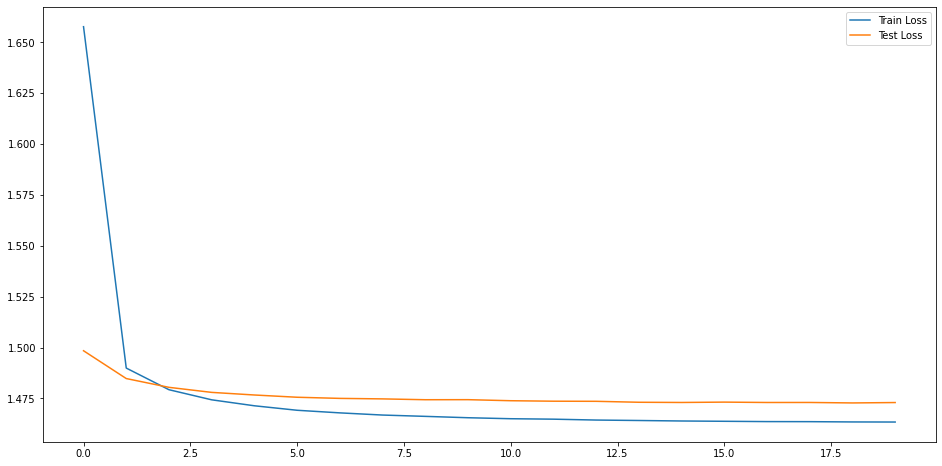

In [4]:
# plot the learning curve
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.gcf().set_size_inches(16, 8)
plt.show()

In [5]:
# get accuracy
def get_accuracy(model, data_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            output = model(data.to(DEVICE))
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.to(DEVICE).view_as(pred)).sum().item()
    return correct / len(data_loader.dataset)

print(f"Train Accuracy: {get_accuracy(model, test_loader)}")

Train Accuracy: 0.9898


In [6]:
from devinterp.slt.rlct_tune_utils import *
# sweep over hyperparams, storing rlct estimate summary
hyperparams = {
    "lr_list": [1e-4, 1e-5, 1e-6],
    "restrict_to_orth_grad_list": [False],
    "optimizer_list": [SGLD],
    "num_samples": [len(train_data)],

    # SGNHT
    "diffusion_factor_list": [0.01],

    # SGLD
    "noise_level_list": [1.0, 2.0],
    "elasticity_list": [100.0],
    "temperature_list": ['adaptive'],

    # chain config
    "num_draws": [100],
    "num_chains": [1],
}

# run parallel jobs
args_list = make_args_list(**hyperparams)
# print(args_list)
rlct_estimate_summary_list = Parallel(n_jobs=8, verbose=10)(
    delayed(get_summary_for_hyperparams)(copy.deepcopy(model), args) 
    for args in args_list)
# rlct_estimate_summary_list = [get_summary_for_hyperparams(copy.deepcopy(model), args) for args in args_list]
# print(args_list)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   6 | elapsed:  5.1min remaining: 10.2min
[Parallel(n_jobs=8)]: Done   3 out of   6 | elapsed:  5.1min remaining:  5.1min
[Parallel(n_jobs=8)]: Done   4 out of   6 | elapsed:  5.2min remaining:  2.6min
[Parallel(n_jobs=8)]: Done   6 out of   6 | elapsed:  5.2min finished


lr: 0.0001, SGLD, noise_level: 1.0, elasticity: 100.0, temperature: adaptive, num_draws: 100, num_samples: 60000, restrict_to_orth_grad: False, num_chains: 1, 
lr: 0.0001, SGLD, noise_level: 2.0, elasticity: 100.0, temperature: adaptive, num_draws: 100, num_samples: 60000, restrict_to_orth_grad: False, num_chains: 1, 
lr: 1e-05, SGLD, noise_level: 1.0, elasticity: 100.0, temperature: adaptive, num_draws: 100, num_samples: 60000, restrict_to_orth_grad: False, num_chains: 1, 
lr: 1e-05, SGLD, noise_level: 2.0, elasticity: 100.0, temperature: adaptive, num_draws: 100, num_samples: 60000, restrict_to_orth_grad: False, num_chains: 1, 
lr: 1e-06, SGLD, noise_level: 1.0, elasticity: 100.0, temperature: adaptive, num_draws: 100, num_samples: 60000, restrict_to_orth_grad: False, num_chains: 1, 
lr: 1e-06, SGLD, noise_level: 2.0, elasticity: 100.0, temperature: adaptive, num_draws: 100, num_samples: 60000, restrict_to_orth_grad: False, num_chains: 1, 


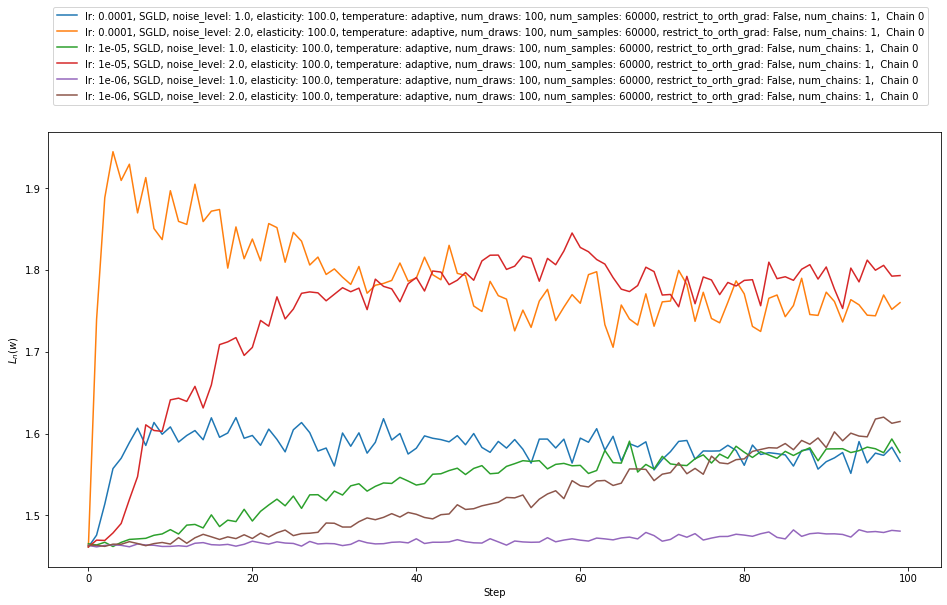

In [7]:
# plot summary traces
args_list = make_args_list(**hyperparams)
for rlct_estimate_summary, args in zip(rlct_estimate_summary_list, args_list):
    # make label out of args
    label = ""
    for key, value in args.items():
        if key == "optimizer":
            label += f"{value.__name__}, "
        else:
            label += f"{key}: {value}, "
    print(label)
    trace = rlct_estimate_summary['trace']
    for chain, df in trace.groupby("chain"):
        plt.plot(df["step"], df["loss"], label= f"{label} Chain {chain}")
plt.xlabel("Step")
plt.ylabel(r"$L_n(w)$")
#make legend below plot
plt.legend(bbox_to_anchor=(0, 1.05), loc='lower left')
plt.gcf().set_size_inches(16, 8)

In [8]:
[(rlct_estimate_summary_list[i]['mean'], rlct_estimate_summary_list[i]['std']) for i in range(len(rlct_estimate_summary_list))]

[(661.1089477539062, nan),
 (1780.804931640625, nan),
 (413.61700439453125, nan),
 (1565.9019775390625, nan),
 (34.535850524902344, nan),
 (325.1622619628906, nan)]